# Predict response to stimuli: lstm for time series

In a *lstm timeseries* problem, we aim to predict the response of a stimuli, as a time series data. The input is a stimuli vs time and the output is response vs time curve. Depending on how we train the network the response curve could represent average response to the stimuli from different spatial locations or could represet response form a single spatial location. 

This notebook builds an LSTM based model to predict the response to external stimuli. To do this, we'll provide the model with timeseries of stimuli and use the return sequences to return an output vector that has the same shape as that of the input time series, the output represents response to the stimuli.

In [141]:
import keras, tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The input csv file contains N columns of response as tabular data, we load the data from disk and read it to a numpy array

In [148]:
stimuli_data = pd.read_csv("../stimuli_response_data/stimuli.csv")
stimuli_data_tuple = stimuli_data.to_numpy()
stimuli_data_array = np.asarray(stimuli_data_tuple)
type(stimuli_data_array)

stimuli_data_array = np.reshape(stimuli_data_array, (stimuli_data_array.shape[1], stimuli_data_array.shape[0], 1))

print("input data shape",stimuli_data_array.shape)
for i in range(stimuli_data_array.shape[0]):
    mean, std = stimuli_data_array[i,:,:].mean(axis = 0), stimuli_data_array[i,:,:].std(axis = 0)
    
    stimuli_data_array[i,:,:] = ( stimuli_data_array[i,:,:] - mean ) / std


input data shape (4, 999, 1)


In [149]:
input_shape = (stimuli_data_array.shape[1],stimuli_data_array.shape[2])
lstm_units = 16
learning_rate = 0.01
epochs = 150
batch_size = 4
validation_split = 0.1

Now we create the ground truth data which are responses from specific locations that correspond to the stimuli

In [164]:
response_data = pd.read_csv("../stimuli_response_data/stimuli.csv")
response_data_tuple = response_data.to_numpy()
response_data_array = np.asarray(response_data_tuple)
type(response_data_array)
response_data_array = np.reshape(response_data_array, (response_data_array.shape[1], response_data_array.shape[0]))


The dataset contains 4 colums of the stimuli and the first number represents the number of timepoints present in the data

In [165]:
from keras import layers, models
from keras.layers import ConvLSTM1D, LSTM, Conv1D, Dense, Bidirectional
img_input = layers.Input(shape = input_shape)
x = (LSTM(lstm_units, return_sequences=True))(img_input)


x = Dense(1, activation= 'linear')(x)
outputs = x
model = models.Model(img_input, outputs)
opt = keras.optimizers.RMSprop(lr=learning_rate)

model.compile(loss='mse',
              optimizer=opt, metrics = ['mae'])
model.summary()

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 999, 1)]          0         
                                                                 
 lstm_94 (LSTM)              (None, 999, 16)           1152      
                                                                 
 dense_14 (Dense)            (None, 999, 1)            17        
                                                                 
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


c:\Users\rando\anaconda3\envs\naparienv\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Now let us plot the network graph using keras plot_model

<IPython.core.display.Image object>


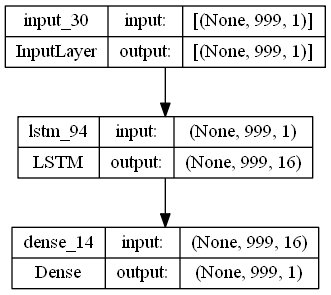

In [166]:
from keras.utils import plot_model

model_inline = plot_model(model, to_file = './model_time_series.png', 
show_shapes = True, show_layer_names=True)

print(model_inline)
model_inline

Now let us start the model training by first defining some parameters like epochs, validation_split, keras callbacks etc

In [170]:

history = model.fit(stimuli_data_array, response_data_array,
              batch_size=batch_size,
              epochs=epochs,
              verbose = True,
              validation_split= validation_split,
              shuffle=True)

Epoch 1/150
1/1 [==============================] - 0s 240ms/step - loss: 0.0018 - mae: 0.0375 - val_loss: 0.0040 - val_mae: 0.0625
Epoch 2/150
1/1 [==============================] - 0s 101ms/step - loss: 0.0017 - mae: 0.0358 - val_loss: 2.8362e-04 - val_mae: 0.0124
Epoch 3/150
1/1 [==============================] - 0s 90ms/step - loss: 0.0018 - mae: 0.0369 - val_loss: 0.0034 - val_mae: 0.0575
Epoch 4/150
1/1 [==============================] - 0s 77ms/step - loss: 0.0013 - mae: 0.0312 - val_loss: 1.8194e-04 - val_mae: 0.0081
Epoch 5/150
1/1 [==============================] - 0s 109ms/step - loss: 0.0013 - mae: 0.0301 - val_loss: 0.0028 - val_mae: 0.0519
Epoch 6/150
1/1 [==============================] - 0s 81ms/step - loss: 0.0010 - mae: 0.0272 - val_loss: 2.1564e-04 - val_mae: 0.0088
Epoch 7/150
1/1 [==============================] - 0s 94ms/step - loss: 0.0011 - mae: 0.0269 - val_loss: 0.0028 - val_mae: 0.0502
Epoch 8/150
1/1 [==============================] - 0s 102ms/step - loss: 0.

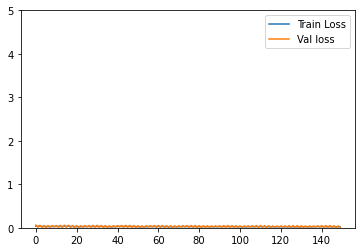

In [171]:
def plot_history(history):
  plt.figure()
  plt.plot(history.epoch, np.array(history.history['mae']),
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mae']),
           label = 'Val loss')
  plt.legend()
  plt.ylim([0, 5])

plot_history(history)

32/32 [==============================] - 0s 6ms/step
(999, 1)
Prediction


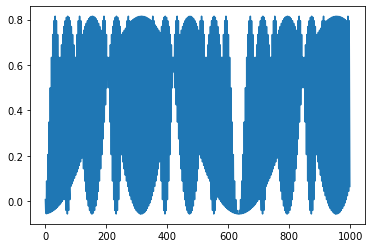

GT


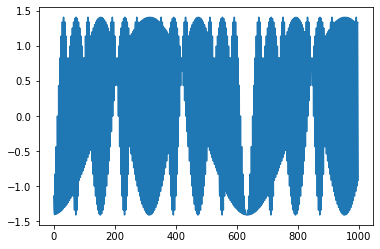

In [172]:
prediction = model.predict(stimuli_data_array[0,:,:])[:,:,0]
print(prediction.shape)
print('Prediction')
plt.plot(prediction)
plt.show()
print('GT')
plt.plot(stimuli_data_array[0,:,:])
plt.show()
